In [1]:
### written by Shubham Dutta, SINP
### Reference - numerical recipes in C++

import numpy as np
import sys
import matplotlib
from matplotlib import pyplot as plt




In [4]:

ASWITCH = 100
ngau = 18

y = [ 0.0021695375159141994, 0.011413521097787704, 0.027972308950302116,
      0.051727015600492421, 0.082502225484340941, 0.12007019910960293,
      0.16415283300752470, 0.21442376986779355, 0.27051082840644336,
      0.33199876341447887, 0.39843234186401943, 0.46931971407375483,
      0.54413605556657973, 0.62232745288031077, 0.70331500465597174,
      0.78649910768313447, 0.87126389619061517, 0.95698180152629142 ]

w = [ 0.0055657196642445571, 0.012915947284065419, 0.020181515297735382,
      0.027298621498568734, 0.034213810770299537, 0.040875750923643261,
      0.047235083490265582, 0.053244713977759692, 0.058860144245324798,
      0.064039797355015485, 0.068745323835736408, 0.072941885005653087,
      0.076598410645870640, 0.079687828912071670, 0.082187266704339706,
      0.084078218979661945, 0.085346685739338721, 0.085983275670394821 ]


EPS   = sys.float_info.epsilon
FPMIN = sys.float_info.min/EPS


def gammln( xx ):


#    Returns the value ln(Gamma(xx) for xx > 0.  Full accuracy is obtained for
#    xx > 1. For 0 < xx < 1. the reflection formula (6.1.4) can be used first.
#    (Adapted from Numerical Recipes in C.  Relative to that routine, this
#    subtracts one from x at the very start, and in exchange does not have to
#    divide ser by x at the end.  The results are formally equal, and practically
#    indistinguishable.)

     cof = [ 76.18009172947146,-86.50532032941677,
             24.01409824083091, -1.231739572450155,
             0.1208650973866179e-2, -0.5395239384953e-5 ]

     x = xx - 1.0
     tmp = x + 5.5
     tmp -= (x + 0.5) * np.log(tmp)
     ser = 1.000000000190015

     for j in range(0,6):
         x += 1.0
         ser += cof[j]/x

     return ( -tmp + np.log(2.5066282746310005*ser) )



def gammpapprox(a, x, psig):
    a1 = a-1.0
    lna1 = np.log(a1)
    sqrta1 = np.sqrt(a1)
    gln = gammln(a)
    if (x > a1):
        xu = max(a1 + 11.5*sqrta1, x + 6.0*sqrta1)
    else:
        xu = max(0., min(a1 - 7.5*sqrta1, x - 5.0*sqrta1))
    sum = 0.
    for j in range(0,ngau):
        t = x + (xu-x) * y[j]
        sum += w[j] * np.exp( -(t-a1) + a1*(np.log(t)-lna1) )

    ans = sum * (xu-x)*exp( a1*(lna1-1.) - gln )
#    return (psig?(ans>0.0? 1.0-ans:-ans):(ans>=0.0? ans:1.0+ans))
    return ( ((1.0-ans) if ans>0. else -ans) if psig else (ans if ans>=0. else 1.+ans) )


def gser(a, x):
    gln = gammln(a)
    ap = a
    delta = 1./a
    sum = 1./a
    while( True ):
        ap += 1
        delta *= x/ap
        sum += delta

        if( (np.abs(delta) < np.abs(sum)*EPS) ):
            return sum*np.exp(-x+a*np.log(x)-gln)
            break


def gcf(a, x):
    gln = gammln(a)
    b = x + 1.0 - a
    c = 1.0/FPMIN
    d = 1.0/b
    h = d
    i = 1
    while( True ):
        an = -i*(i-a)
        b += 2.0
        d = an*d+b
        if(np.abs(d) < FPMIN):
            d=FPMIN
        c = b+an/c

        if( np.abs(c) < FPMIN):
            c=FPMIN
        d = 1.0/d

        delta = d*c
        h *= delta
        if( np.abs(delta-1.0) <= EPS):
            break

        i += 1

    return np.exp(-x+a*np.log(x)-gln)*h




def gammq(a, x):
    if (x < 0.0 or a <= 0.0):
        print("ERROR: bad args in gammq")
        sys.exit(1)
    if (x == 0.0):
#        print("CHECK1")
        return 1.0
    elif( int(a) >= ASWITCH ):
#        print("CHECK2")
        return gammpapprox(a,x,0)
    elif( x < a+1.0 ):
#        print("CHECK3")
        return 1.0 - gser(a,x)
    else:
        return gcf(a,x)






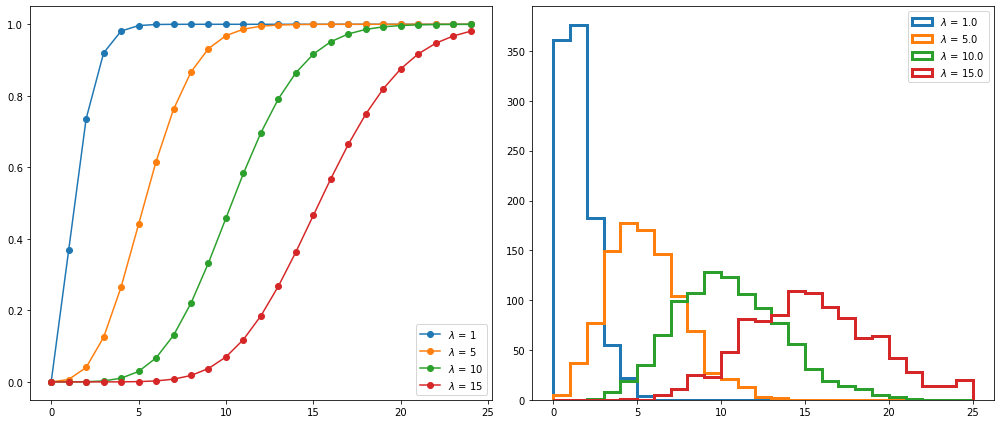

In [5]:
class PoissonDist():

    lam = 0

    # Constructor
    def __init__(self, lam):
            self.lam = lam
            if( lam <= 0. ):
                print("ERROR: lambda value cannot be less than 0")
                sys.exit(1)


    def p(self, n):
        if( n < 0 ):
            print("ERROR: bad n in PoisssonDist")
            sys.exit(1)
        return np.exp( -self.lam + n*np.log(self.lam) - gammln(n+1.) )


    def cdf(self, n):
        if ( n < 0 ):
            print("ERROR: bad n in PoissonDist")
            sys.exit(1)

        if ( n==0 ):
            return 0.

        return gammq(n, self.lam)


    def invcdf(self, p):
        n = 1
        nl = 1
        nu = 1
        inc = 1

        if( p < 0. or p > 1. ) :
            print("ERROR: bad p in PoissonDist")
            sys.exit(1)

        if( p < np.exp( -self.lam ) ):
            return 0.

        n = int( max(np.sqrt(self.lam), 5.) )

        if( p < self.cdf( n ) ):
            while( True ):
                n = max( n-inc, 0. )
                inc *= 2.

                if( p > self.cdf( n ) ):
                    break
            nl = n
            nu = n + inc/2.

        else:
            while( True ):
                n += inc
                inc *= 2.

                if( p < self.cdf( n ) ):
                    break
            nu = n
            nl = n - inc/2.

        while( (nu - nl) > 1. ):
            n = (nl + nu)/2.
            if( p < self.cdf(n) ):
                nu = n
            else:
                nl = n
        return nl



fig  = plt.figure( figsize=(14,6) )
axes1 = fig.add_subplot(121)
axes2 = fig.add_subplot(122)

a = PoissonDist( 1.0 )
b = PoissonDist( 5.0 )
c = PoissonDist( 10.0 )
d = PoissonDist( 15.0 )

#print a.p( 10 )

x = range(0,25)
#y = [ a.p(ix) for ix in x ]

#plt.plot( x, y, '-o')
#plt.show()

ya = [ a.cdf(ix) for ix in x ]
yb = [ b.cdf(ix) for ix in x ]
yc = [ c.cdf(ix) for ix in x ]
yd = [ d.cdf(ix) for ix in x ]

axes1.plot( x, ya, '-o', label="$\lambda$ = 1")
axes1.plot( x, yb, '-o', label="$\lambda$ = 5")
axes1.plot( x, yc, '-o', label="$\lambda$ = 10")
axes1.plot( x, yd, '-o', label="$\lambda$ = 15")
axes1.legend()

#fig.set_tight_layout(True)
#plt.show()
#fig.savefig("poisson_cdf.png", dpi = 100)
#fig.savefig("poisson_cdf.pdf", format="pdf")


p = np.random.uniform(0., 1., 1000)
xa = [ a.invcdf(ip) for ip in p ]
xb = [ b.invcdf(ip) for ip in p ]
xc = [ c.invcdf(ip) for ip in p ]
xd = [ d.invcdf(ip) for ip in p ]


axes2.hist( xa, bins=25, range=(0,25),
          label="$\lambda$ = 1.0", histtype="step",
          linewidth=3.0 )

axes2.hist( xb, bins=25, range=(0,25),
          label="$\lambda$ = 5.0", histtype="step",
          linewidth=3.0 )

axes2.hist( xc, bins=25, range=(0,25),
          label="$\lambda$ = 10.0", histtype="step",
          linewidth=3.0 )

axes2.hist( xd, bins=25, range=(0,25),
          label="$\lambda$ = 15.0", histtype="step",
          linewidth=3.0 )

axes2.legend(loc = "upper right")

fig.set_tight_layout(True)
plt.show()
fig.savefig("poissonDist.png", dpi = 100)
fig.savefig("poissonDist.pdf", format="pdf")







